In [1]:
import numpy as np
import time

np.random.seed(100)

# aux = np.zeros(100)
# aux[:35] = 1
# aux[-35:] = -1
# np.random.shuffle(aux)


N = 100 # np.random.randint(100, 201)          # число спутников
data = np.zeros((N, 6), dtype=object)         # массив со всей информацией
data[:, :2] = np.random.random_sample((N, 2)) # x и y каждой точки
data[:, 2] = np.random.randint(-1, 2, N)      # источник/сток/ничего
data[:, 3] = np.random.randint(4, 11, N)      # число связей (соседей) каждой точки

array = np.array([[-1, 0], [0, 0], [1, 0]])

# функция, рандомно генерирующая соседей для каждой точки
def get_neighbours():

    bonds = np.zeros(N, dtype=object)
    bonds += data[:, 3]
    if sum(bonds) % 2 != 0:
        bonds[list(bonds).index(max(bonds))] -= 1
    
    bonds_dictionary = {}
    for i in range(N):
        bonds_dictionary[i] = bonds[i]

    dictionary_items = list(bonds_dictionary.items())
    dictionary_items.sort(key=lambda i: i[1])
    dictionary_items = dictionary_items[::-1]
    
    keys = []
    neighbours_total = []
    for i in range(N):
        keys.append(dictionary_items[i][0])
        neighbours_total.append([])
        
    while len(keys) > 0:
        n = keys[0]
        del keys[0]
        x_n = data[n, 0]
        y_n = data[n, 1]
        distances = np.zeros(N, dtype=object)
        
        for i in range(N):
            distance_variants = np.zeros(3)
            for j in range(3):
                distance_variants[j] = ((x_n - (data[i, 0] + array[j][0])) ** 2 + (y_n - (data[i, 1] + array[j][1])) ** 2) ** (1 / 2)
            distances[i] = [np.argmin(distance_variants), distance_variants[np.argmin(distance_variants)]]
            
        radius = 0
        points_in_radius = []
        while len(points_in_radius) < bonds[n]:
            for i in range(N):
                if distances[i][1] < radius and i != n and not i in [neib[1] for neib in neighbours_total[n]] and not i in points_in_radius and i in keys:
                    points_in_radius.append(i)
            radius += 0.01
            if radius > 2 ** (1 / 2):
                raise OverflowError

        neighbours = np.random.choice(points_in_radius, int(bonds[n]), False)
        
        neighbours_total[n] += [[array[distances[neib][0]], neib] for neib in neighbours]
        
        for neib in neighbours:
            neighbours_total[neib].append([array[distances[neib][0]]*-1, n])
            bonds[neib] -= 1
            if bonds[neib] == 0:
                del keys[keys.index(neib)]

    return neighbours_total


# не всегда функции get_neighbours() удается распределить соседей корректно для всех точек c 1 раза, поэтому:
for i in range(10):
    try:
        t = time.time()
        neighbours = get_neighbours()    
        print(-t+ time.time())
        break
    except OverflowError:
        continue
        
for i in range(N):
    data[i, 4] = neighbours[i]

0.12889981269836426


In [2]:
s = time.time()
s - time.time()

-2.6941299438476562e-05

In [3]:
class Point:

    def __init__(self, number):
        self.number = number                     # номер точки
        self.x = np.round(data[number, 0], 3)    # х
        self.y = np.round(data[number, 1], 3)    # у
        self.u = data[number, 2]                 # значение функции u
        self.bounds = data[number, 3]            # число соседей
        self.neighbours = data[number, 4]        # соседи

    # заполнение матрицы системы А для каждой точки, не являющейся стоком/источником (чтобы найти коэффициенты
    # разложения лапласиана)
        if self.u == 0:
            dxdy = np.zeros((self.bounds, 2))
            
            for i in range(self.bounds):
                dxdy[i, 0] = (data[self.neighbours[i][1], 0] + self.neighbours[i][0][0]) - self.x
                dxdy[i, 1] = (data[self.neighbours[i][1], 1] + self.neighbours[i][0][1]) - self.y
                
            self.A = np.zeros((self.bounds + 1, self.bounds + 1))
            self.A[0, :] = np.ones(self.bounds + 1)
            self.A[1, 1:] = dxdy[:, 0]
            self.A[2, 1:] = dxdy[:, 1]
            self.A[3, 1:] = dxdy[:, 0] ** 2
            self.A[4, 1:] = dxdy[:, 1] ** 2

            if self.bounds == 4:
                self.b = np.array([0, 0, 0, 2, 2])

            if self.bounds == 5:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.b = np.array([0, 0, 0, 2, 2, 0])

            if self.bounds == 6:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.b = np.array([0, 0, 0, 2, 2, 0, 0])

            if self.bounds == 7:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0])

            if self.bounds == 8:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0])

            if self.bounds == 9:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.A[9, 1:] = dxdy[:, 1] ** 3
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0, 0])

            if self.bounds == 10:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.A[9, 1:] = dxdy[:, 1] ** 3
                self.A[10, 1:] = dxdy[:, 0] ** 4
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0])

            self.alpha = np.linalg.solve(self.A, self.b)  # коэффициенты разложения лапласиана

# функция для вывода информации о точке через интерфейс
    def inp(self):
        data_neighbours = ''
        for i in range(self.bounds):
            m = self.neighbours[i][1]
            data_neighbours += f'\n{(m, np.round(data[m, 0], 3), np.round(data[m, 1], 3), np.round(((self.x - (data[m, 0] + self.neighbours[i][0][0])) ** 2 + (self.y - (data[m, 1] + self.neighbours[i][0][1])) ** 2) ** (1 / 2), 3))}'
        return [self.number, (self.x, self.y), data_neighbours, self.u]



points = [0] * N  # массив точек

for i in range(N):
    points[i] = Point(i)

In [4]:
n = 50  # число итераций
for i in range(n):
    u = [point.u for point in points]
    for point in points:
        if point.u != 1 and point.u != -1:
            for j in range(point.bounds):
                point.u -= point.alpha[j + 1] * u[point.neighbours[j][1]] / point.alpha[0]
print(u)

[-1, 1, -1, -1, -1, -206576823.598671, -67.89651864976321, -1.6462307699138416e+20, -1, 1, 1, -1, -1, -258251607.5866017, -1, 6.6042227059524956e+22, -4.12245138308479e+17, 2.839490084447823e+20, -1, 1, 4.086158597235011e+23, 1, -1, -1, 1, 1, -1.3377190231851945e+20, 2.613969187917483e+21, -1, 1, -1, -1, -6.601597573501577e+20, 1, 1, 1, 1, 1, -1.9256298330266398e+21, -1, -4.645944622309481e+25, -1, -1.628271273570832e+21, -1, 1, 1, -1, -1, 2.089250197128103e+20, -1, -7.301517131535245e+22, 1, 1.9037817622463464e+22, 1, -1, -1, -9.690050958085457e+20, -9.06066376197337e+18, 1, -1, 1.739061400106206e+21, -6.021903013536031e+26, -1, -3.41032547678094e+20, 1, 1, 1, -1, -3.7119201919583457e+22, 4.750586225424388e+20, -1, 3.84840944549365e+26, -283416096.3522742, -1, -1, 1, 1.4057030656752282e+22, -1, 1.3330216611880913e+22, -1, 7.82249944478747e+18, 9.095741788558321e+22, -2.219662744765768e+23, -1, 5.342217168818379e+22, -1, 1, -1.3307878011471523e+20, 1, 2.687008710632556e+20, 1, -1, 1, 1

In [5]:
from tkinter import *

#  from tkinter import Canvas

map_window = Tk()
map_window.title('Карта спутников')
map_window.geometry('700x700')


def get_info(number):
    dot_window = Toplevel(map_window)
    dot_window.title(f'Спутник № {number}')
    Label(dot_window, text='Номер').grid(row=0, column=0)
    Label(dot_window, text='Координаты').grid(row=1, column=0)
    Label(dot_window, text='Соседи').grid(row=2, column=0)
    Label(dot_window, text='Значение u').grid(row=3, column=0)
    for i in range(4):
        Label(dot_window, text=f'{points[number].inp()[i]}').grid(row=i, column=1)


dot_buttons = []

for i in range(len(points)):
    dot = Button(map_window, text=f'{i}', font='Arial 10', width=3, height=1,
                 command=lambda i=i: get_info(i))
    dot_buttons.append(dot)
    dot.place(relx=points[i].x, rely=points[i].y)
    if points[i].u == 1:
        dot.config(highlightbackground='pink')
    elif points[i].u == -1:
        dot.config(highlightbackground='yellow')



def search():
    search_window = Toplevel(map_window)
    search_window.title('Поиск')
    search_number = Entry(search_window)
    search_number.pack()

    def get_entry():
        value = search_number.get()
        dot_buttons[int(value)].config(highlightbackground='red')

    button = Button(search_window, text='Найти', command=get_entry)
    button.pack()


def exit_app():
    map_window.destroy()


main_menu = Menu(map_window)
map_window.config(menu=main_menu)

actions = Menu(main_menu)
main_menu.add_cascade(label='Действия', menu=actions)
actions.add_command(label='Поиск по номеру', command=search)
actions.add_command(label='Выход', command=exit_app)
#  canvas = Canvas()
#  canvas.pack()
#  canvas.create_line(points[1].x, points[1].y, points[2].x, points[2].y)
map_window.mainloop()
N=100

In [7]:
import numpy as np

np.random.seed(6)
nc = 81                # число ячеек
k = int(np.sqrt(nc))    # корень из числа ячеек
n = 1                     # число спутников в ячейке
N = n*nc                   # число спутников
l = 1/k                    # длина стороны ячейки
data = np.zeros((N, 6), dtype=object)  # массив со всей информацией
for i in range(k):
    for j in range(k):
        data[((k * i + j) * n):((k * i + j + 1) * n), 0] = np.random.random_sample(n) * l + l * j
        data[((k * i + j) * n):((k * i + j + 1) * n), 1] = np.random.random_sample(n) * l + l * i
data[:, 2] = np.random.randint(-1, 2, N)  # источник/сток/ничего
data[:, 3] = np.random.randint(4, 8, N)  # число связей (соседей) каждой точки


# функция, рандомно генерирующая соседей для каждой точки
def get_neighbours():
    # коррекция общего число связей
    if sum(data[:, 3]) % 2 != 0:
        data[np.argmax(data[:, 3]), 3] -= 1

    bonds = np.zeros(N, dtype=object)
    bonds += data[:, 3]
    sorted_bonds = sorted([[j, bonds[j]] for j in range(N)], key=lambda j: j[1], reverse=True)
    keys = []
    neighbours_total = []

    for k in range(N):
        keys.append(sorted_bonds[k][0])
        neighbours_total.append([])

    for p in range(N):
        if bonds[p] == 0:
            del keys[keys.index(p)]
    array = np.array([-1, 0, 1])
    max_distance = 0.3
    while len(keys) > 0:
        n = keys[0]
        del keys[0]
        x_n = data[n, 0]
        y_n = data[n, 1]
        distances = np.zeros(N, dtype=object)

        for l in range(N):
            distance_variants = np.zeros(3)
            for j in range(3):
                distance_variants[j] = ((data[l, 0] - (x_n + array[j])) ** 2 +
                                        (data[l, 1] - y_n) ** 2) ** (1 / 2)
            distances[l] = [np.argmin(distance_variants), distance_variants[np.argmin(distance_variants)]]

        radius = 0
        points_in_radius = []
        while len(points_in_radius) < bonds[n]:
            for k in range(N):
                if (distances[k][1] < radius) and not (k in points_in_radius) and not \
                        (k in [neib[0] for neib in neighbours_total[n]]) and (k in keys) and \
                        (k != n):  # and not(k in [m[0] for m in data[n, 4]]):
                    points_in_radius.append(k)
            radius += 0.01
            if radius > 2 ** (1 / 2):
                raise OverflowError
        aux = [[p, distances[p]] for p in points_in_radius]
        sorted_aux = sorted(aux, key=lambda j: j[1])
        points_in_radius = [a[0] for a in sorted_aux[:bonds[n]]]

        neibs = np.random.choice(points_in_radius, int(bonds[n]), False)
        neighbours_total[n] += [[neib, array[distances[neib][0]]] for neib in neibs]
        # print(f'Number: {n}')
        # print([(element, distances[element[0]][1]) for element in neighbours_total[n]] )
        for neib in neibs:
            bonds[neib] -= 1
            if bonds[neib] == 0:
                del keys[keys.index(neib)]

            if distances[neib][1] < max_distance:
                neighbours_total[neib].append([n, array[distances[neib][0]] * -1])
            else:
                data[n, 3] -= 1
                data[neib, 3] -= 1
                del neighbours_total[n][neighbours_total[n].index([neib, array[distances[neib][0]]])]

        # print(f'Number: {n}')  #}\nNeighbours ({data[n, 3]}):\n{[[v[0], np.round(distances[v[0]][1], 4)] for v in neighbours_total[n]]}')
    return neighbours_total


# число связей (соседей) каждой точки
# не всегда функции get_neighbours() удается распределить соседей корректно для всех точек c 1 раза, поэтому:
for i in range(1000):
    try:
        # print('e')
        neighbours = get_neighbours()
        break
    except OverflowError:
        continue

for i in range(N):
    data[i, 4] = sorted(neighbours[i], key=lambda j: j[0])


In [9]:
import numpy as np



class Point:

    def __init__(self, number):
        self.number = number  # номер точки
        self.x = data[number, 0]  # х
        self.y = data[number, 1]  # у
        self.bounds = data[number, 3]  # число соседей
        self.neighbours = data[number, 4]  # соседи
        self.calculate_distance()
        # self.distances = [self.calculate_distance(neib[0], neib[1]) for neib in self.neighbours]
        # self.distances = [((data[neib[0], 0] - (data[self.number, 0] + neib[1])) ** 2 +
        #                    (data[neib[0], 1] - data[self.number, 1]) ** 2) ** (1 / 2) for neib in
        #                   self.neighbours]

    def calculate_distance(self):
        self.distances = [((data[neib[0], 0] - (data[self.number, 0] + neib[1])) ** 2 +
                           (data[neib[0], 1] - data[self.number, 1]) ** 2) ** (1 / 2) for neib in self.neighbours]

    def add_neighbour(self, neighbour, period=0):
        neighbour.bounds += 1
        self.bounds += 1
        self.neighbours = np.vstack((self.neighbours, [neighbour.number, period]))
        neighbour.neighbours = np.vstack((neighbour.neighbours, [self.number, -period]))
        self.calculate_distance()
        neighbour.calculate_distance()

    def delete_neighbour(self, neighbour):
        neighbour.bounds -= 1
        self.bounds -= 1

        self.neighbours = np.delete(self.neighbours, [neib[0] for neib in self.neighbours].index(neighbour.number), 0)
        neighbour.neighbours = np.delete(neighbour.neighbours,
                                         [neib[0] for neib in neighbour.neighbours].index(self.number), 0)
        self.calculate_distance()
        neighbour.calculate_distance()

    # функция для вывода информации о точке через интерфейс
    def inp(self):
        data_neighbours = ''
        for i in range(self.bounds):
            neib = self.neighbours[i][0]
            data_neighbours += f'\n{(neib, np.round(data[neib, 0], 3), np.round(data[neib, 1], 3), np.round(self.distances[i], 3), data[neib, 2])} '
        return [self.number, (np.round(self.x, 3), np.round(self.y, 3)), data_neighbours]


points = [Point(k) for k in range(N)]  # массив точек
points[25].add_neighbour(points[26])
points[60].add_neighbour(points[43])
points[60].add_neighbour(points[43])
points[25].add_neighbour(points[34])
points[26].add_neighbour(points[35])
points[40].add_neighbour(points[41])
points[10].add_neighbour(points[11])
points[10].add_neighbour(points[0])
points[7].delete_neighbour(points[26])
points[20].delete_neighbour(points[28])
points[27].add_neighbour(points[28])
points[27].delete_neighbour(points[19])
points[60].add_neighbour(points[52])
points[65].add_neighbour(points[47])
points[3].add_neighbour(points[12])
points[44].delete_neighbour(points[27])

data[1, 2] = 1
data[73, 2] = -1
data[6, 2] = -1
data[0, 2] = 1
data[2, 2] = 0
data[20, 2] = 0
data[41, 2] = 0
data[18, 2] = 1
data[56, 2] = 1
data[66, 2] = -1
data[61, 2] = -1
data[51, 2] = -1
data[15, 2] = 0
data[25, 2] = 1
data[9, 2] = -1
data[23, 2] = -1
data[60, 2] = 1
data[44, 2] = 0

In [10]:
for i in range(N):
    points[i].u = data[i, 2]
    if points[i].u == 0:
        dx = np.zeros(points[i].bounds)
        dy = np.zeros(points[i].bounds)

        for j in range(points[i].bounds):
            dx[j] = data[points[i].neighbours[j][0], 0] - (points[i].x + points[i].neighbours[j][1])
            dy[j] = data[points[i].neighbours[j][0], 1] - points[i].y

        points[i].A = np.zeros((points[i].bounds + 1, points[i].bounds + 1))
        points[i].A[0, :] = np.ones(points[i].bounds + 1)
        points[i].A[1, 1:] = dx
        points[i].b = np.array([0, 0])

        if points[i].bounds == 2:
            points[i].A[2, 1:] = dy
            points[i].b = np.array([0, 0, 0])

        if points[i].bounds == 3:
            points[i].A[2, 1:] = dy
            points[i].A[3, 1:] = dx ** 2
            points[i].b = np.array([0, 0, 0, 2])

        if points[i].bounds == 4:
            points[i].A[2, 1:] = dy
            points[i].A[3, 1:] = dx ** 2
            points[i].A[4, 1:] = dy ** 2
            points[i].b = np.array([0, 0, 0, 2, 2])


        if points[i].bounds == 5:
            points[i].A[2, 1:] = dy
            points[i].A[3, 1:] = dx ** 2
            points[i].A[4, 1:] = dy ** 2
            points[i].A[5, 1:] = dx ** 2 * dy ** 2
            points[i].b = np.array([0, 0, 0, 2, 2, 0])
            # if np.linalg.det(points[i].A) == 0:
            #     points[i].A[2, 1:] = dy
            #     points[i].A[3, 1:] = dx ** 2
            #     points[i].A[4, 1:] = dy ** 2
            #     points[i].A[5, 1:] = dx ** 3
            #     points[i].b = np.array([0, 0, 0, 2, 2, 0, 0])

        if points[i].bounds == 6:
            points[i].A[2, 1:] = dy
            points[i].A[3, 1:] = dx ** 2
            points[i].A[4, 1:] = dy ** 2
            points[i].A[5, 1:] = dx ** 2 * dy ** 2
            points[i].A[6, 1:] = dy * dx
            points[i].b = np.array([0, 0, 0, 2, 2, 0, 0])
            # if np.linalg.det(points[i].A) == 0:
            #     points[i].A[2, 1:] = dy
            #     points[i].A[3, 1:] = dx ** 2
            #     points[i].A[4, 1:] = dy ** 2
            #     points[i].A[5, 1:] = dx ** 3
            #     points[i].A[6, 1:] = dx ** 2 * dy
            #     points[i].b = np.array([0, 0, 0, 2, 2, 0, 0])

        if points[i].bounds == 7:
            points[i].A[2, 1:] = dy
            points[i].A[3, 1:] = dx ** 2
            points[i].A[4, 1:] = dy ** 2
            points[i].A[5, 1:] = dx ** 3
            points[i].A[6, 1:] = dy ** 3
            points[i].A[7, 1:] = dx ** 4
            points[i].b = np.array([0, 0, 0, 2, 2, 0, 0, 0])

        if points[i].bounds == 8:
            points[i].A[2, 1:] = dy
            points[i].A[3, 1:] = dx ** 2
            points[i].A[4, 1:] = dy ** 2
            points[i].A[5, 1:] = dx ** 3
            points[i].A[6, 1:] = dy ** 3
            points[i].A[7, 1:] = dx ** 4
            points[i].A[8, 1:] = dy ** 4
            points[i].b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0])

        if points[i].bounds == 9:
            points[i].A[2, 1:] = dy
            points[i].A[3, 1:] = dx ** 2
            points[i].A[4, 1:] = dy ** 2
            points[i].A[5, 1:] = dx ** 3
            points[i].A[6, 1:] = dy ** 3
            points[i].A[7, 1:] = dx ** 4
            points[i].A[8, 1:] = dy ** 4
            points[i].A[9, 1:] = dx ** 5
            points[i].b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0, 0])

        if points[i].bounds == 10:
            points[i].A[2, 1:] = dy
            points[i].A[3, 1:] = dx ** 2
            points[i].A[4, 1:] = dy ** 2
            points[i].A[5, 1:] = dx ** 3
            points[i].A[6, 1:] = dy ** 3
            points[i].A[7, 1:] = dx ** 4
            points[i].A[8, 1:] = dy ** 4
            points[i].A[9, 1:] = dx ** 5
            points[i].A[10, 1:] = dy ** 5
            points[i].b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0])

        # print(f'Number: {points[i].number} \nNeighbours: {points[i].neighbours} \nMatrix with det {np.linalg.det(
        # points[i].A)}: \n{points[i].A}')
        points[i].alpha = np.linalg.solve(points[i].A, points[i].b)  # коэффициенты разложения лапласиана
        # print(points[i].alpha)
# make_interface(points)
u0 = [point.u for point in points]
# print(u0)
A = np.eye(N)
F = np.zeros(N)
u = u0
for point in points:
    if point.u != 1 and point.u != -1:
        # A[point.number, point.number] = 0
        for j in range(point.bounds):
            A[point.number, point.number] = point.alpha[0]
            A[point.number, point.neighbours[j][0]] = point.alpha[j + 1]
    else:
        F[point.number] = point.u

# matrix_A = ps.DataFrame(A)
# matrix_A.to_excel("matrix_A.xlsx")

A_abs = np.fabs(A)
bad_lines = 0
good_lines = 0
ist = 0
st = 0
none = 0
for i in range(N):
    if points[i].u != 1 and points[i].u != -1:
        none += 1
        if 2*A_abs[i, i] - sum(A_abs[i]) > 0:
            good_lines += 1
            # print(i, 2*A_abs[i, i] - sum(A_abs[i]))
        else:
            bad_lines += 1
            # print(i, 2*A_abs[i, i] - sum(A_abs[i]))
    elif points[i].u == 1:
        ist += 1
    else:
        st += 1

print(f'sources:   {ist}')
print(f'drains:    {st}')
print(f'nones:     {none}')
# print(f'good lines:       {good_lines}')
# print(f'bad lines:        {bad_lines}')

U = np.triu(A, 1)
L = np.tril(A, -1)
D = np.diag(np.diag(A))
B = np.linalg.inv(D)
I = 100  # число итераций

for i in range(I):
    u_new = - np.dot(np.dot(B, L + U), u) + np.dot(B, F)
    u = u_new
bad = 0
for i in range(N):
    points[i].u = u[i]
    # if u[i] > 1 or u[i] < -1:
    #     bad += 1
    print((i, np.round(u[i], 3)), '                      ', [(points[i].neighbours[j][0], np.round(points[i].distances, 3)[j]) for j in range(points[i].bounds)])
print(f'bad:   {bad}')

sources:   28
drains:    28
nones:     25
(0, 1.0)                        [(1, 0.108), (2, 0.138), (8, 0.12), (9, 0.166), (10, 0.155)]
(1, 1.0)                        [(0, 0.108), (2, 0.069), (3, 0.194), (9, 0.224), (10, 0.205), (11, 0.218)]
(2, 0.289)                        [(0, 0.138), (1, 0.069), (3, 0.159), (12, 0.207), (19, 0.222)]
(3, 1.0)                        [(1, 0.194), (2, 0.159), (4, 0.092), (12, 0.126)]
(4, -1.0)                        [(3, 0.092), (5, 0.123), (12, 0.124), (13, 0.15), (14, 0.136), (23, 0.223)]
(5, -0.56)                        [(4, 0.123), (6, 0.121), (14, 0.054)]
(6, -1.0)                        [(5, 0.121), (7, 0.133), (14, 0.143), (15, 0.159), (16, 0.146), (23, 0.19)]
(7, -0.388)                        [(6, 0.133), (8, 0.145), (15, 0.152), (16, 0.087), (17, 0.133), (25, 0.144)]
(8, -1.0)                        [(0, 0.12), (7, 0.145)]
(9, -1.0)                        [(0, 0.166), (1, 0.224), (10, 0.023), (17, 0.142), (18, 0.059), (19, 0.077)]
(10, -0.99

In [13]:
import plotly.graph_objects as go

u_for_plot = [[None for x in range(N)] for y in range(N)]
x_dict = {}
y_dict = {}
for i in range(N):
    x_dict[i] = points[i].x
    y_dict[i] = points[i].y
    
x_items = list(x_dict.items())
x_items.sort(key=lambda i: i[1])

y_items = list(y_dict.items())
y_items.sort(key=lambda i: i[1])

x = np.zeros(N)
y = np.zeros(N)
r= 0
for i in range(N):
    x[i] = x_items[i][1]
    for j in range(N):
        y[i] = y_items[i][1]
        if x_items[i][0] == y_items[j][0]:
            u_for_plot[j][i] = points[x_items[i][0]].u
            r+=1
for i in range(N):
    x[i] = points[i].x
    y[i] = points[i].y
    u[i] = points[i].u
            
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=u, mode='markers')])
fig.show()

In [14]:
import pandas as ps
ps.DataFrame(u_for_plot)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: Argument Z must be 2-dimensional.

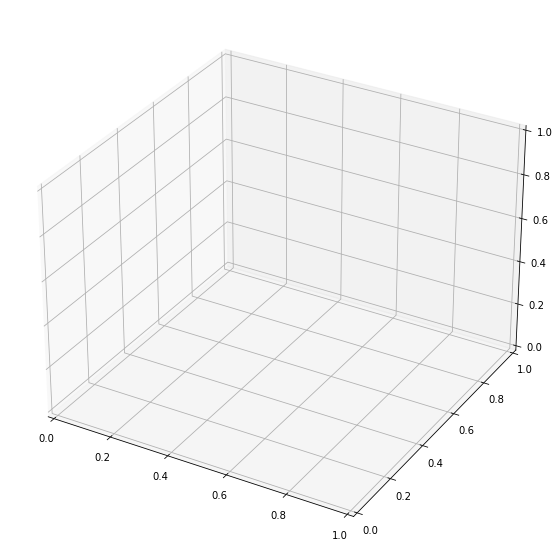

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
# уравнение поверхности
f = u
# создаём полотно для рисунка
fig = plt.figure(figsize = (10, 10))
# создаём рисунок пространства с поверхностью
ax = fig.add_subplot(1, 1, 1, projection = '3d')
# размечаем границы осей для аргументов
xval = x
yval = y
# создаём массив с xval столбцами и yval строками
# - в этом массиве будут храниться значения z
x, y = np.meshgrid(xval, yval)
# приравниваем z к функции от x и y 
z = u
# создаём поверхность
surf = ax.plot_surface(
# отмечаем аргументы и уравнение поверхности
x, y, z, 
# шаг прорисовки сетки
# - чем меньше значение, тем плавнее
# - будет градиент на поверхности
rstride = 10,
cstride = 10,
# цветовая схема plasma
cmap = cm.plasma)

In [35]:
xval = np.linspace(0, 5, 6)
yval = np.linspace(0, 5, 6)
x, y = np.meshgrid(xval, yval)
f = lambda x, y: x + y 
u = f(x, y)
u

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 2.,  3.,  4.,  5.,  6.,  7.],
       [ 3.,  4.,  5.,  6.,  7.,  8.],
       [ 4.,  5.,  6.,  7.,  8.,  9.],
       [ 5.,  6.,  7.,  8.,  9., 10.]])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

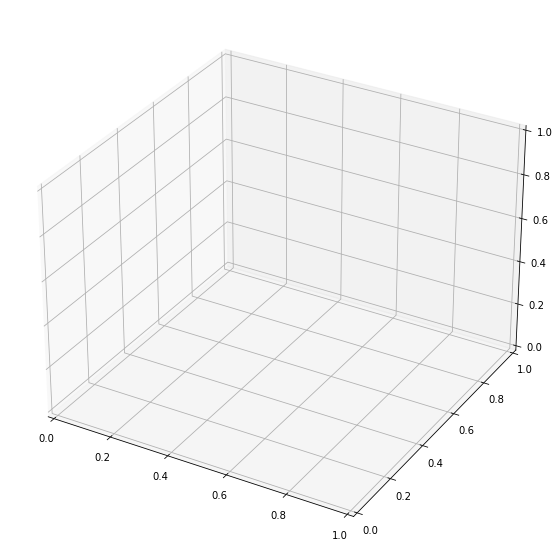

In [37]:
u_for_plot = [[None for x in range(N)] for y in range(N)]
x_dict = {}
y_dict = {}
for i in range(N):
    x_dict[i] = points[i].x
    y_dict[i] = points[i].y
    
x_items = list(x_dict.items())
x_items.sort(key=lambda i: i[1])

y_items = list(y_dict.items())
y_items.sort(key=lambda i: i[1])

x = np.zeros(N)
y = np.zeros(N)
r= 0
for i in range(N):
    x[i] = x_items[i][1]
    for j in range(N):
        y[i] = y_items[i][1]
        if x_items[i][0] == y_items[j][0]:
            u_for_plot[j][i] = points[x_items[i][0]].u
            
fig = plt.figure(figsize = (10, 10))
x, y = np.meshgrid(xval, yval)
# создаём рисунок пространства с поверхностью
ax = fig.add_subplot(1, 1, 1, projection = '3d')
z = np.array(u_for_plot)
# создаём поверхность
surf = ax.plot_surface(
# отмечаем аргументы и уравнение поверхности
x, y, z, 
# шаг прорисовки сетки
# - чем меньше значение, тем плавнее
# - будет градиент на поверхности
rstride = 2,
cstride = 2,
cmap = cm.viridis)

In [33]:
array1 = np.array([['л' for x in range(3)] for y in range(N)], dtype=object)
for i in range(N):
    if not points[i].u == 1 and not points[i].u == -1:
        array1[i, 0] = np.fabs(points[i].alpha[0])
        array1[i, 1] = sum(np.fabs(points[i].alpha)) - np.fabs(points[i].alpha[0])
        array1[i, 2] = 2*np.fabs(points[i].alpha[0]) - sum(np.fabs(points[i].alpha))
b = ps.DataFrame(array1, range(N), ('a0', '|a1|+...+|an|', '|a0| - sum'))
b.to_excel("diag_preob.xlsx")

In [34]:
a = np.ones(3)*-1


In [206]:
np.fabs(a)

array([1., 1., 1.])

In [207]:
sum(a)

-3.0

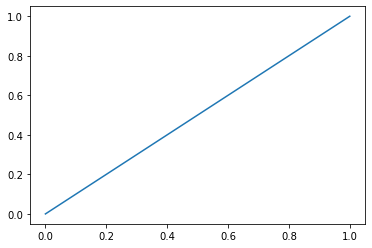

In [171]:
import matplotlib.pyplot as plt
fig = plt.figure()
graph1 = plt.plot([None, 1.0, 0], [2, 1.0, 0])
plt.show()

In [14]:
from tkinter import *
from tkinter import Canvas

map_window = Tk()
map_window.title('Карта спутников')
map_window.geometry('700x700')
#ph = PhotoImage(file = 'test1.png')
#f = Label(map_window, image=ph)

#ph = PhotoImage(file = 'ppp.png')
#f = Label(map_window, image=ph)
#f.photo =ph
#f.pack()



def get_info(number):
    dot_window = Toplevel(map_window)
    dot_window.title(f'Спутник № {number}')
    Label(dot_window, text='Номер').grid(row=0, column=0)
    Label(dot_window, text='Координаты').grid(row=1, column=0)
    Label(dot_window, text='Соседи').grid(row=2, column=0)
    Label(dot_window, text='Значение u').grid(row=3, column=0)
    for i in range(4):
        Label(dot_window, text=f'{points[number].inp()[i]}').grid(row=i, column=1)


dot_buttons = []
for i in range(len(points)):
    dot = Button(map_window, text=f'{i}', font='Arial 10', width=3, height=1,
                 command=lambda i=i: get_info(i))
    dot_buttons.append(dot)
    dot.place(relx=points[i].x, rely=points[i].y)
    if points[i].u == 1:
        dot.config(highlightbackground='pink')
    elif points[i].u == -1:
        dot.config(highlightbackground='yellow')



def search():
    search_window = Toplevel(map_window)
    search_window.title('Поиск')
    search_number = Entry(search_window)
    search_number.pack()

    def get_entry():
        value = search_number.get()
        dot_buttons[int(value)].config(highlightbackground='red')

    button = Button(search_window, text='Найти', command=get_entry)
    button.pack()


def exit_app():
    map_window.destroy()


main_menu = Menu(map_window)
map_window.config(menu=main_menu)

actions = Menu(main_menu)
main_menu.add_cascade(label='Действия', menu=actions)
actions.add_command(label='Поиск по номеру', command=search)
actions.add_command(label='Выход', command=exit_app)
   
        
map_window.mainloop()

from tkinter import *
from tkinter import Canvas

map_window = Tk()
map_window.title('Карта спутников')
map_window.geometry('700x700')
#ph = PhotoImage(file = 'test1.png')
#f = Label(map_window, image=ph)

#ph = PhotoImage(file = 'ppp.png')
#f = Label(map_window, image=ph)
#f.photo =ph
#f.pack()



def get_info(number):
    dot_window = Toplevel(map_window)
    dot_window.title(f'Спутник № {number}')
    Label(dot_window, text='Номер').grid(row=0, column=0)
    Label(dot_window, text='Координаты').grid(row=1, column=0)
    Label(dot_window, text='Соседи').grid(row=2, column=0)
    Label(dot_window, text='Значение u').grid(row=3, column=0)
    for i in range(4):
        Label(dot_window, text=f'{points[number].inp()[i]}').grid(row=i, column=1)


dot_buttons = []
for i in range(len(points)):
    dot = Button(map_window, text=f'{i}', font='Arial 10', width=3, height=1,
                 command=lambda i=i: get_info(i))
    dot_buttons.append(dot)
    dot.place(relx=points[i].x, rely=points[i].y)
    if points[i].u == 1:
        dot.config(highlightbackground='pink')
    elif points[i].u == -1:
        dot.config(highlightbackground='yellow')



def search():
    search_window = Toplevel(map_window)
    search_window.title('Поиск')
    search_number = Entry(search_window)
    search_number.pack()

    def get_entry():
        value = search_number.get()
        dot_buttons[int(value)].config(highlightbackground='red')

    button = Button(search_window, text='Найти', command=get_entry)
    button.pack()


def exit_app():
    map_window.destroy()


main_menu = Menu(map_window)
map_window.config(menu=main_menu)

actions = Menu(main_menu)
main_menu.add_cascade(label='Действия', menu=actions)
actions.add_command(label='Поиск по номеру', command=search)
actions.add_command(label='Выход', command=exit_app)
   
        
map_window.mainloop()
from tkinter import *
from tkinter import Canvas

map_window = Tk()
map_window.title('Карта спутников')
map_window.geometry('700x700')
#ph = PhotoImage(file = 'test1.png')
#f = Label(map_window, image=ph)

#ph = PhotoImage(file = 'ppp.png')
#f = Label(map_window, image=ph)
#f.photo =ph
#f.pack()



def get_info(number):
    dot_window = Toplevel(map_window)
    dot_window.title(f'Спутник № {number}')
    Label(dot_window, text='Номер').grid(row=0, column=0)
    Label(dot_window, text='Координаты').grid(row=1, column=0)
    Label(dot_window, text='Соседи').grid(row=2, column=0)
    Label(dot_window, text='Значение u').grid(row=3, column=0)
    for i in range(4):
        Label(dot_window, text=f'{points[number].inp()[i]}').grid(row=i, column=1)


dot_buttons = []
for i in range(len(points)):
    dot = Button(map_window, text=f'{i}', font='Arial 10', width=3, height=1,
                 command=lambda i=i: get_info(i))
    dot_buttons.append(dot)
    dot.place(relx=points[i].x, rely=points[i].y)
    if points[i].u == 1:
        dot.config(highlightbackground='pink')
    elif points[i].u == -1:
        dot.config(highlightbackground='yellow')



def search():
    search_window = Toplevel(map_window)
    search_window.title('Поиск')
    search_number = Entry(search_window)
    search_number.pack()

    def get_entry():
        value = search_number.get()
        dot_buttons[int(value)].config(highlightbackground='red')

    button = Button(search_window, text='Найти', command=get_entry)
    button.pack()


def exit_app():
    map_window.destroy()


main_menu = Menu(map_window)
map_window.config(menu=main_menu)

actions = Menu(main_menu)
main_menu.add_cascade(label='Действия', menu=actions)
actions.add_command(label='Поиск по номеру', command=search)
actions.add_command(label='Выход', command=exit_app)
   
        
map_window.mainloop()

In [141]:
import numpy as np
#from PIL import Image, ImageDraw

np.random.seed(100)

N = 100 #np.random.randint(100, 201)  # число точек
data = np.zeros((N, 6), dtype=object)  # массив со всей информацией
data[:, :2] = np.random.random_sample((N, 2))  # x и y каждой точки
data[:, 2] = np.random.randint(4, 11, N)  # число связей (соседей) каждой точки
data[:, 4] = np.random.randint(-1, 2, N)  # источник/сток/ничего


array = [[-1, 1], [0, 1], [1, 1],
         [-1, 0], [0, 0], [1, 0],
         [-1,-1], [0,-1], [1,-1]]

# функция, рандомно генерирующая соседей для каждой точки
def get_neighbours(bg_size):
    
    #image = Image.new("RGB", (bg_size, bg_size), 'lightblue')
    #draw = ImageDraw.Draw(image)
    
    bonds = np.zeros(N, dtype=object)
    bonds += data[:, 2]
    if sum(bonds) % 2 != 0:
        bonds[list(bonds).index(max(bonds))] -= 1

    dictionary = {}
    for i in range(N):
        dictionary[i] = bonds[i]

    dictionary_items = list(dictionary.items())
    dictionary_items.sort(key=lambda i: i[1])
    dictionary_items = dictionary_items[::-1]

    keys = []
    all_neighbours = []
    neib_marks = []
    for i in range(N):
        keys.append(dictionary_items[i][0])
        all_neighbours.append([])
        neib_marks.append([])
    while len(keys) > 0:
        n = keys[0]
        del keys[0]
        x_n = data[n, 0]
        y_n = data[n, 1]
        
        
        distances = np.zeros(N, dtype=object)
        distance_marks = np.zeros(N)
        x_n = data[n, 0]
        y_n = data[n, 1]
        for i in range(N):
            distance_vars = np.zeros(9)
            for j in range(9):
                distance_vars[j] = ((x_n - (data[i, 0] + array[j][0])) ** 2 + (y_n - (data[i, 1] + array[j][1])) ** 2) ** (1 / 2)
#                             [((x_n - data[i, 0]) ** 2 + (y_n - data[i, 1]) ** 2) ** (1 / 2),
#                              ((x_n - (data[i, 0] + 1)) ** 2 + (y_n - data[i, 1]) ** 2) ** (1 / 2), 
#                              ((x_n - data[i, 0]) ** 2 + (y_n - (data[i, 1] + 1)) ** 2) ** (1 / 2), 
#                              ((x_n - (data[i, 0] + 1)) ** 2 + (y_n - (data[i, 1] + 1)) ** 2) ** (1 / 2), 
#                              ((x_n - (data[i, 0] - 1)) ** 2 + (y_n - data[i, 1]) ** 2) ** (1 / 2),
#                              ((x_n - data[i, 0]) ** 2 + (y_n - (data[i, 1] - 1)) ** 2) ** (1 / 2),
#                              ((x_n - (data[i, 0] - 1)) ** 2 + (y_n - (data[i, 1] - 1)) ** 2) ** (1 / 2),
#                              ((x_n - (data[i, 0] - 1)) ** 2 + (y_n - (data[i, 1] + 1)) ** 2) ** (1 / 2),
#                              ((x_n - (data[i, 0] + 1)) ** 2 + (y_n - (data[i, 1] - 1)) ** 2) ** (1 / 2), ]
            distances[i] = [np.argmin(distance_vars), distance_vars[np.argmin(distance_vars)]]
#                             min(((x_n - data[i, 0]) ** 2 + (y_n - data[i, 1]) ** 2) ** (1 / 2),
#                                ((x_n - (data[i, 0] + 1)) ** 2 + (y_n - data[i, 1]) ** 2) ** (1 / 2),
#                                ((x_n - data[i, 0]) ** 2 + (y_n - (data[i, 1] + 1)) ** 2) ** (1 / 2),
#                                ((x_n - (data[i, 0] + 1)) ** 2 + (y_n - (data[i, 1] + 1)) ** 2) ** (1 / 2),
#                                ((x_n - (data[i, 0] - 1)) ** 2 + (y_n - data[i, 1]) ** 2) ** (1 / 2),
#                                ((x_n - data[i, 0]) ** 2 + (y_n - (data[i, 1] - 1)) ** 2) ** (1 / 2),
#                                ((x_n - (data[i, 0] - 1)) ** 2 + (y_n - (data[i, 1] - 1)) ** 2) ** (1 / 2),
#                                ((x_n - (data[i, 0] - 1)) ** 2 + (y_n - (data[i, 1] + 1)) ** 2) ** (1 / 2),
#                                ((x_n - (data[i, 0] + 1)) ** 2 + (y_n - (data[i, 1] - 1)) ** 2) ** (1 / 2))
            
            
            
        radius = 0
        points_in_radius = []
        while len(points_in_radius) < bonds[n]:
            for i in range(N):
                if distances[i][1] < radius and i != n and not i in all_neighbours[n] and not i in points_in_radius and i in keys:
                    points_in_radius.append(i)
            radius += 0.01
            if radius > 2 ** (1 / 2):
                raise OverflowError

        neighbours = list(np.random.choice(points_in_radius, int(bonds[n]), False))
        #print(neighbours)
        neighbours_total = [[distances[neib][0], neib] for neib in neighbours]
        print('!!!!', n, neighbours)
        all_neighbours[n] += neighbours
        neib_marks[n] += neighbours_total
        for neib in neighbours:
            #draw.line((x_n*bg_size, y_n*bg_size, data[neib, 0]*bg_size, data[neib, 1]*bg_size))

            all_neighbours[neib].append(n)
            neib_marks[neib].append([distances[neib][0], n])
            print(n,neib, all_neighbours[neib], neib_marks[neib])
            bonds[neib] -= 1
            if bonds[neib] == 0:
                del keys[keys.index(neib)]
    #image.save("/Users/sofiakim/Desktop/test1.png", "PNG")

    return all_neighbours, neib_marks


# не всегда функции get_neighbours() удается распределить соседей корректно для всех точек c 1 раза, поэтому:
for i in range(10):
    try:
        neighbours = get_neighbours(700)[0]
        neib_marks = get_neighbours(700)[1]
        break
    except OverflowError:
        continue

for i in range(N):
    data[i, 3] = sorted(neighbours[i])

print(N)




class Point:

    def __init__(self, number):
        self.number = number                     # номер точки
        self.x = np.round(data[number, 0], 3)    # х
        self.y = np.round(data[number, 1], 3)    # у
        self.bounds = data[number, 2]            # число соседей
        self.neighbours = data[number, 3]        # соседи
        self.u = data[number, 4]                 # значение функции u

    # заполнение матрицы системы А для каждой точки, не являющейся стоком/источником (чтобы найти коэффициенты
    # разложения лапласиана)
        if self.u == 0:
            dxdy = np.zeros((len(self.neighbours), 2))
            for i in range(len(self.neighbours)):
                dxdy[i, 0] = data[self.neighbours[i], 0] - self.x
                dxdy[i, 1] = data[self.neighbours[i], 1] - self.y
                if self.number == 5:
                    print(self.neighbours[i])
            self.A = np.zeros((len(self.neighbours) + 1, len(self.neighbours) + 1))
            self.A[0, :] = np.ones(len(self.neighbours) + 1)
            self.A[1, 1:] = dxdy[:, 0]
            self.A[2, 1:] = dxdy[:, 1]
            self.A[3, 1:] = dxdy[:, 0] ** 2
            self.A[4, 1:] = dxdy[:, 1] ** 2

            if len(self.neighbours) == 4:
                self.b = np.array([0, 0, 0, 2, 2])

            if len(self.neighbours) == 5:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.b = np.array([0, 0, 0, 2, 2, 0])

            if len(self.neighbours) == 6:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.b = np.array([0, 0, 0, 2, 2, 0, 0])

            if len(self.neighbours) == 7:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0])

            if len(self.neighbours) == 8:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0])

            if len(self.neighbours) == 9:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.A[9, 1:] = dxdy[:, 1] ** 3
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0, 0])

            if len(self.neighbours) == 10:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.A[9, 1:] = dxdy[:, 1] ** 3
                self.A[10, 1:] = dxdy[:, 0] ** 4
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0])

            self.alpha = np.linalg.solve(self.A, self.b)  # коэффициенты разложения лапласиана

# функция, возвращающаяя расстояние между двумя точками
    def distance(self, other):
        if isinstance(other, int):
            return ((self.x - data[other, 0]) ** 2 + (self.y - data[other, 1]) ** 2) ** (1 / 2)
        if isinstance(other, Point):
            return ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** (1 / 2)

# функция для вывода информации о точке через интерфейс
    def inp(self):
        data_neighbours = ''
        for i in range(self.bounds):
            m = self.neighbours[i]
            data_neighbours += f'\n{(m, np.round(data[m, 0], 3), np.round(data[m, 1], 3), np.round(((self.x - data[m, 0]) ** 2 + (self.y - data[m, 1]) ** 2) ** (1 / 2), 3))}'
        return [self.number, (self.x, self.y), data_neighbours, self.u]



points = [0] * N  # массив точек

for i in range(N):
    points[i] = Point(i)

    
    
#print(e)

!!!! 90 [68, 43, 53, 3, 76, 14, 50, 98, 84, 82]
90 68 [90] [[4, 90]]
90 43 [90] [[4, 90]]
90 53 [90] [[4, 90]]
90 3 [90] [[4, 90]]
90 76 [90] [[4, 90]]
90 14 [90] [[1, 90]]
90 50 [90] [[4, 90]]
90 98 [90] [[4, 90]]
90 84 [90] [[4, 90]]
90 82 [90] [[4, 90]]
!!!! 79 [77, 42, 63, 83, 57, 27, 91, 34, 35, 62]
79 77 [79] [[4, 79]]
79 42 [79] [[4, 79]]
79 63 [79] [[4, 79]]
79 83 [79] [[4, 79]]
79 57 [79] [[4, 79]]
79 27 [79] [[4, 79]]
79 91 [79] [[4, 79]]
79 34 [79] [[4, 79]]
79 35 [79] [[4, 79]]
79 62 [79] [[4, 79]]
!!!! 78 [64, 38, 0, 51, 62, 77, 33, 58, 45, 15]
78 64 [78] [[4, 78]]
78 38 [78] [[4, 78]]
78 0 [78] [[4, 78]]
78 51 [78] [[4, 78]]
78 62 [79, 78] [[4, 79], [4, 78]]
78 77 [79, 78] [[4, 79], [4, 78]]
78 33 [78] [[4, 78]]
78 58 [78] [[4, 78]]
78 45 [78] [[4, 78]]
78 15 [78] [[4, 78]]
!!!! 63 [27, 42, 62, 91, 77, 45, 83, 34, 64]
63 27 [79, 63] [[4, 79], [4, 63]]
63 42 [79, 63] [[4, 79], [4, 63]]
63 62 [79, 78, 63] [[4, 79], [4, 78], [4, 63]]
63 91 [79, 63] [[4, 79], [4, 63]]
63 77 [

63 64 [78, 63] [[4, 78], [4, 63]]
63 27 [79, 63] [[4, 79], [4, 63]]
63 0 [78, 63] [[4, 78], [4, 63]]
63 91 [79, 63] [[4, 79], [4, 63]]
!!!! 55 [54, 67, 2, 72, 66, 18, 85, 13, 5, 65]
55 54 [55] [[3, 55]]
55 67 [55] [[4, 55]]
55 2 [55] [[4, 55]]
55 72 [55] [[3, 55]]
55 66 [55] [[3, 55]]
55 18 [55] [[3, 55]]
55 85 [55] [[4, 55]]
55 13 [55] [[4, 55]]
55 5 [55] [[3, 55]]
55 65 [55] [[4, 55]]
!!!! 46 [67, 74, 12, 75, 28, 13, 65, 57, 16, 99]
46 67 [55, 46] [[4, 55], [4, 46]]
46 74 [46] [[4, 46]]
46 12 [46] [[4, 46]]
46 75 [46] [[4, 46]]
46 28 [46] [[4, 46]]
46 13 [55, 46] [[4, 55], [4, 46]]
46 65 [55, 46] [[4, 55], [4, 46]]
46 57 [79, 46] [[4, 79], [4, 46]]
46 16 [46] [[4, 46]]
46 99 [46] [[4, 46]]
!!!! 42 [83, 64, 91, 35, 62, 27, 34, 0, 45]
42 83 [79, 63, 42] [[4, 79], [4, 63], [4, 42]]
42 64 [78, 63, 42] [[4, 78], [4, 63], [4, 42]]
42 91 [79, 63, 42] [[4, 79], [4, 63], [4, 42]]
42 35 [79, 42] [[4, 79], [4, 42]]
42 62 [79, 78, 63, 42] [[4, 79], [4, 78], [4, 63], [4, 42]]
42 27 [79, 63, 42] [

!!!! 66 [25]
66 25 [95, 69, 17, 89, 56, 66] [[3, 95], [4, 69], [3, 17], [3, 89], [4, 56], [7, 66]]
!!!! 65 [12, 28]
65 12 [46, 75, 65] [[4, 46], [4, 75], [4, 65]]
65 28 [46, 6, 65] [[4, 46], [4, 6], [4, 65]]
!!!! 50 [43, 87]
50 43 [90, 98, 82, 52, 20, 50] [[4, 90], [4, 98], [4, 82], [4, 52], [4, 20], [4, 50]]
50 87 [95, 17, 56, 50] [[3, 95], [3, 17], [4, 56], [4, 50]]
!!!! 44 [59, 26, 30]
44 59 [76, 47, 93, 44] [[4, 76], [4, 47], [4, 93], [4, 44]]
44 26 [22, 49, 47, 48, 93, 44] [[4, 22], [4, 49], [4, 47], [4, 48], [4, 93], [4, 44]]
44 30 [49, 47, 48, 93, 44] [[4, 49], [4, 47], [4, 48], [4, 93], [4, 44]]
!!!! 40 [21, 10, 61, 1]
40 21 [41, 52, 81, 40] [[1, 41], [1, 52], [1, 81], [4, 40]]
40 10 [41, 7, 81, 40] [[4, 41], [4, 7], [4, 81], [7, 40]]
40 61 [41, 81, 40] [[1, 41], [1, 81], [4, 40]]
40 1 [41, 7, 81, 40] [[4, 41], [4, 7], [4, 81], [7, 40]]
!!!! 38 [8, 19]
38 8 [11, 23, 14, 94, 38] [[4, 11], [4, 23], [4, 14], [4, 94], [4, 38]]
38 19 [20, 73, 38] [[4, 20], [4, 73], [4, 38]]
!!!! 36 

!!!! 83 [80, 62, 74]
83 80 [29, 49, 75, 48, 83] [[4, 29], [4, 49], [4, 75], [4, 48], [4, 83]]
83 62 [79, 78, 63, 42, 83] [[4, 79], [4, 78], [4, 63], [4, 42], [4, 83]]
83 74 [46, 75, 83] [[4, 46], [4, 75], [4, 83]]
!!!! 73 [39, 16, 19, 37, 70]
73 39 [29, 22, 73] [[4, 29], [4, 22], [5, 73]]
73 16 [46, 29, 67, 13, 73] [[4, 46], [4, 29], [4, 67], [4, 13], [5, 73]]
73 19 [20, 73] [[4, 20], [4, 73]]
73 37 [29, 95, 20, 73] [[3, 29], [3, 95], [4, 20], [4, 73]]
73 70 [29, 22, 95, 49, 48, 73] [[4, 29], [4, 22], [4, 95], [4, 49], [4, 48], [5, 73]]
!!!! 66 [25]
66 25 [95, 69, 17, 89, 56, 66] [[3, 95], [4, 69], [3, 17], [3, 89], [4, 56], [7, 66]]
!!!! 65 [12, 28]
65 12 [46, 75, 65] [[4, 46], [4, 75], [4, 65]]
65 28 [46, 6, 65] [[4, 46], [4, 6], [4, 65]]
!!!! 50 [43, 87]
50 43 [90, 98, 82, 52, 20, 50] [[4, 90], [4, 98], [4, 82], [4, 52], [4, 20], [4, 50]]
50 87 [95, 17, 56, 50] [[3, 95], [3, 17], [4, 56], [4, 50]]
!!!! 44 [26, 30, 80]
44 26 [22, 49, 47, 48, 93, 44] [[4, 22], [4, 49], [4, 47], [4, 48

In [3]:
from tkinter import *
from PIL import Image, ImageDraw


wind = Tk()
wind.title('окно')
wind.geometry('700x700')

ph = PhotoImage(file = 'ppp.png')
bg = Label(wind, image=ph)
bg.photo = ph
bg.pack()
w = ph.width()
h = ph.height()
wind.mainloop()

In [17]:
from tkinter import *
from PIL import Image, ImageDraw

wind = Tk()
wind.title('окно')
wind.geometry('700x700')

image = Image.new("RGB", (700, 700), 'lightblue')
draw = ImageDraw.Draw(image)
draw.line((100, 0, 100, 600))
image.save("/Users/sofiakim/Desktop/test2.png", "PNG")

ph1 = PhotoImage(file = 'test2.png')
bg1 = Label(wind, image=ph1)
bg1.photo = ph1
bg1.pack()
w1 = ph1.width()
h1 = ph1.height()

but = Button(wind, text='a', font='Arial 10', width=3, height=1)
but.place(relx=1/7, rely=0.5)

wind.mainloop()